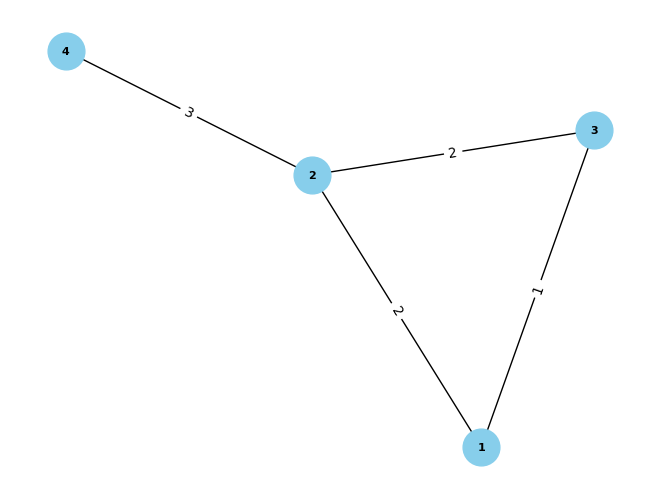

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

# Create a graph with 10 nodes
G = nx.Graph()

# Add nodes to the graph
nodes = 4

G.add_nodes_from(range(1, nodes))
G.add_edge(1, 2, weight=2)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 2, weight=2)
G.add_edge(2, 4, weight=3)

# Plot the graph with weights
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)

# Add edge labels with weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

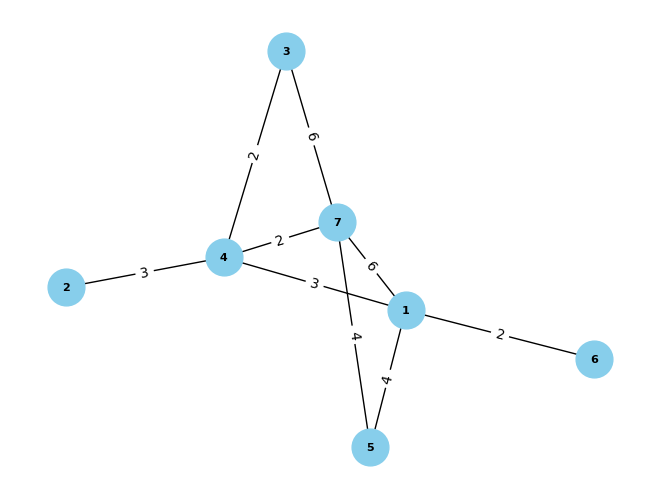

In [89]:
# Create a graph with 10 nodes
G = nx.Graph()

# Add nodes to the graph
nodes = 8

G.add_nodes_from(range(1, nodes))
G.add_edge(2, 4, weight=3)
G.add_edge(4, 3, weight=2)
G.add_edge(3, 7, weight=6)
G.add_edge(7, 1, weight=6)
G.add_edge(7, 4, weight=2)
G.add_edge(7, 5, weight=4)
G.add_edge(1, 6, weight=2)
G.add_edge(5, 1, weight=4)
G.add_edge(4, 1, weight=3)

# Plot the graph with weights
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)

# Add edge labels with weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [90]:
'''
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = 'some_path'

print('The data directory is %s' % course_data_dir)

event_file_path = os.path.join(course_data_dir ,'events_US_air_traffic_GMT.txt')
airport_info_file_path = os.path.join(course_data_dir ,'US_airport_id_info.csv')
background_image_file_path = os.path.join(course_data_dir , 'US_air_bg.png')

events = pd.read_csv(event_file_path, delimiter=' ')
airport_info = pd.read_csv(airport_info_file_path, delimiter=',', index_col=0)

print('The data directory is {path}'.format(path=course_data_dir))
print('The event file is at {path}'.format(path=event_file_path))
print('The airport info file is at {path}'.format(path=airport_info_file_path))
print('The visualization background image is at {path}'.format(path=background_image_file_path))
'''

"\n# Select data directory\nimport os\nif os.path.isdir('/coursedata'):\n    course_data_dir = '/coursedata'\nelif os.path.isdir('../data'):\n    course_data_dir = '../data'\nelse:\n    # Specify course_data_dir on your machine\n    course_data_dir = 'some_path'\n\nprint('The data directory is %s' % course_data_dir)\n\nevent_file_path = os.path.join(course_data_dir ,'events_US_air_traffic_GMT.txt')\nairport_info_file_path = os.path.join(course_data_dir ,'US_airport_id_info.csv')\nbackground_image_file_path = os.path.join(course_data_dir , 'US_air_bg.png')\n\nevents = pd.read_csv(event_file_path, delimiter=' ')\nairport_info = pd.read_csv(airport_info_file_path, delimiter=',', index_col=0)\n\nprint('The data directory is {path}'.format(path=course_data_dir))\nprint('The event file is at {path}'.format(path=event_file_path))\nprint('The airport info file is at {path}'.format(path=airport_info_file_path))\nprint('The visualization background image is at {path}'.format(path=background_imag

In [91]:
#events.head()

In [92]:
#event = events.sort_values(by=['StartTime','EndTime']).reset_index(drop=True)

In [93]:
#event.rename(columns={'Duration': 'weight'}, inplace=True)

In [94]:
#event.head()

In [95]:
#G = nx.from_pandas_edgelist(event, 'Source', 'Destination', ['weight'])

# Draw the graph (optional)
#pos = nx.spring_layout(G)
#nx.draw(G, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', pos=pos)
#labels = nx.get_edge_attributes(G, 'Duration')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)

## 1. Weight matrix

In [96]:
def infection_matrix(net):
    
    num_nodes = len(net.nodes())
    infection_array = np.zeros((num_nodes, num_nodes), dtype=float)
                
    return infection_array


def update_time(times_matrix, seed_node):
    
    values = 0
    track = np.array([seed_node - 1])
    
    # What was the min value of the arrange greater than 0 (it-self)--> faster transmission
    indeces = np.where(times_matrix[(seed_node - 1), :] >= 1)
    values = times_matrix[(seed_node - 1), indeces]

    # Check if any new number is not in the existing array
    new_numbers = np.setdiff1d(indeces[0], track)
    track = np.concatenate((track, new_numbers))

    # Update the infection time
    for v, k in zip(values[0], track[1:]):
        
        update = times_matrix[k, :]
        update[update > 0] += v

        # Add the update
        times_matrix[k, :] = update

        # Update indeces and values for the next iteration
        indeces = np.where(times_matrix[k, :] >= 1)
        values = times_matrix[k, indeces]

        # Check if any new number is not in the existing array THE NODE == INDEX
        new_numbers = np.setdiff1d(indeces[0], track)
        #print("new_numbers ROW", new_numbers)

        if new_numbers.size > 0:
            v = times_matrix[k, new_numbers]

            update = times_matrix[new_numbers, :]
            update[update > 0] += v[0]
            # Add the update
            times_matrix[new_numbers, :] = update

            # Concatenate values and times_matrix[k, new_numbers]
            track = np.concatenate((track, new_numbers))

    return track  

def infection(f, track, prob_array, infect_array):
    p = f
    infection_row = np.where(prob_array[track[0], :] >= p, 1, 0)
    infect_array[track[0],:] = infection_row

    for i in infection_row[1:]: # 1, 0, 0, 0
        if i == 1:
            for j in track[1:]: # ..., 1, 1
                infect_row = np.where(prob_array[j, :] >= p, 1, 0)
                infect_array[j,:] = infect_row

                cols = np.where(infect_array[j,:] == 1)
                
                # Check if any new number is not in the existing array
                new_numbers = np.setdiff1d(cols, track)

                # Append the new numbers to the existing array
                track = np.append(track, new_numbers)
        else:
            pass

    return infect_array     


def update_time_prob(times_matrix, infection_matrix, seed_node):
    
    times_matrix = times_matrix * infection_matrix
    
    values = 0
    track = np.array([seed_node - 1])
    
    # What was the min value of the arrange greater than 0 (it-self)--> faster transmission
    indeces = np.where(times_matrix[(seed_node - 1), :] >= 1)
    values = times_matrix[(seed_node - 1), indeces]

    # Check if any new number is not in the existing array
    new_numbers = np.setdiff1d(indeces[0], track)
    track = np.concatenate((track, new_numbers))

    #print("GO INSIDE")
    # Update the infection time
    for v, k in zip(values[0], track[1:]):
        
        update = times_matrix[k, :]
        update[update > 0] += v

        # Add the update
        times_matrix[k, :] = update

        # Update indeces and values for the next iteration
        indeces = np.where(times_matrix[k, :] >= 1)
        values = times_matrix[k, indeces]

        # Check if any new number is not in the existing array THE NODE == INDEX
        new_numbers = np.setdiff1d(indeces[0], track)
        #print("new_numbers ROW", new_numbers)

        if new_numbers.size > 0:
            #print("value ", times_matrix[k, new_numbers])  # aca el Value
            v = times_matrix[k, new_numbers]

            update = times_matrix[new_numbers, :]
            update[update > 0] += v[0]
            # Add the update
            times_matrix[new_numbers, :] = update

            # Concatenate values and times_matrix[k, new_numbers]
            track = np.concatenate((track, new_numbers))
            
    accumulated_sums = {}

    # Initialize accumulated sum variable
    accumulated_sum = 0

    # Iterate through the shortest path lengths
    for node, distance in shortest_paths.items():
        # Add the distance to the accumulated sum
        accumulated_sum += distance

        # Store the accumulated sum in the dictionary
        accumulated_sums[node] = accumulated_sum
        
        
    return times_matrix, track, accumulated_sums    

def match_array_lengths(arr1, arr2):
    len1, len2 = len(arr1), len(arr2)

    if len1 != len2:
        # Resize arr2 to match the length of arr1
        arr2 = np.resize(arr2, len1)

    return arr1, arr2


In [104]:
weight_array = nx.adjacency_matrix(G, weight='weight').todense()
np.random.seed(41)
nod_numbers = len(G.nodes())
probabilities = np.round(np.random.rand(nod_numbers, nod_numbers), decimals=2)
prob_array = np.where(weight_array > 0, probabilities, 0)

seed = 1
times_matrix = nx.adjacency_matrix(G, weight='weight').todense()
shortest_paths = nx.shortest_path_length(G, source=seed_node, weight='weight')

infect_array = infection_matrix(G)
#print(infect_array)

In [105]:
#event

In [113]:
#for seed in list(G.nodes()):
#times_matrix = nx.adjacency_matrix(G, weight='weight').todense()
#shortest_paths = nx.shortest_path_length(G, source=seed, weight='weight')

infect_array = infection_matrix(G)
track_nodes = update_time(times_matrix, seed)

# probability f:
#for f in np.arange(0.1, 1.0, 0.1):

f = 0
infection_array = infection(f, track_nodes, prob_array, infect_array)
times_array, track_array, accumulated_times  = update_time_prob(times_matrix, infection_array, seed_node)

#
acc_times = list(accumulated_times.values())
'''
    if len(track_array > 1):

        #x_values = track_array
        #print("x_values ", x_values)
        #y_values = acc_times
        #print("y_values ", y_values)


        #nodes, time = match_array_lengths(x_values, y_values)
        #print("nodes ", nodes)
        #print("time ", time)


        #x_values_string = nodes.astype(str)



        # Plotting the line plot
        #plt.plot(x_values_string, time, label='seed ={}, p = {}'.format(seed, f))

    else:
        pass
    
    # Adding labels to the axes
    plt.xlabel('Node')
    plt.ylabel('Time infection')

    # Adding a title to the plot
    #plt.title('Line Plot Example')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()
'''

'\n    if len(track_array > 1):\n\n        #x_values = track_array\n        #print("x_values ", x_values)\n        #y_values = acc_times\n        #print("y_values ", y_values)\n\n\n        #nodes, time = match_array_lengths(x_values, y_values)\n        #print("nodes ", nodes)\n        #print("time ", time)\n\n\n        #x_values_string = nodes.astype(str)\n\n\n\n        # Plotting the line plot\n        #plt.plot(x_values_string, time, label=\'seed ={}, p = {}\'.format(seed, f))\n\n    else:\n        pass\n    \n    # Adding labels to the axes\n    plt.xlabel(\'Node\')\n    plt.ylabel(\'Time infection\')\n\n    # Adding a title to the plot\n    #plt.title(\'Line Plot Example\')\n\n    # Adding a legend\n    plt.legend()\n\n    # Display the plot\n    plt.show()\n'

In [114]:
track_nodes
#print("x_values ", x_values)
#y_values = acc_times

array([0, 3, 4, 5, 6, 1, 2])

In [115]:
track_nodes

array([0, 3, 4, 5, 6, 1, 2])

In [116]:
accumulated_times

{1: 0, 6: 2, 4: 5, 5: 9, 3: 14, 7: 19, 2: 25}

In [117]:
acc_times

[0, 2, 5, 9, 14, 19, 25]

In [120]:
times_array

array([[ 0.,  0.,  0.,  3.,  4.,  2.,  6.],
       [ 0.,  0.,  0., 30.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 29.,  0.,  0., 33.],
       [12., 12., 11.,  0.,  0.,  0., 11.],
       [16.,  0.,  0.,  0.,  0.,  0., 16.],
       [ 8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [24.,  0., 24., 20., 22.,  0.,  0.]])

In [119]:
infect_array

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [70]:
event.loc[event.Destination == 41,:]

,Source,Destination,StartTime,EndTime,weight
2004,26,41,1229256000,1229269200,13200
3040,51,41,1229259900,1229264100,4200
4078,26,41,1229263200,1229276400,13200
4489,53,41,1229264700,1229271300,6600
6146,34,41,1229269800,1229291220,21420
...,...,...,...,...,...
180049,26,41,1230093000,1230106320,13320
180068,59,41,1230093540,1230098700,5160
180110,51,41,1230095400,1230098880,3480
180152,26,41,1230098100,1230111840,13740
